In [1]:
from corner import corner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from calibration.least_squares import least_squares, ChainStats

In [2]:
RANDOM_SUBSAMPLE = 10_000

In [3]:
%%time
df = pd.read_csv('ps1_des-ri.csv', engine='pyarrow')

if RANDOM_SUBSAMPLE is not None:
    df = df.sample(n=RANDOM_SUBSAMPLE, replace=False, random_state=0)

x = np.stack([df["des_mag_r"], df["des_mag_i"], df["ps1_mag_r"]], axis=1)
sigma2 = np.stack([df["des_magerr_r"], df["des_magerr_i"], df["ps1_magerr_r"]], axis=1)**2

del df

CPU times: user 2.17 s, sys: 504 ms, total: 2.67 s
Wall time: 435 ms


In [4]:
%%time
t, y = x[:, :-1], x[:, -1]
A = np.concatenate([t, np.ones((x.shape[0], 1))], axis=1)
sqrt_w = np.sqrt(1 / np.sum(sigma2[:, :-1], axis=1))
(*ord_slopes, ord_intercept), ord_chi2, ord_rank, _ord_s = np.linalg.lstsq(A * sqrt_w[:, None], y * sqrt_w, rcond=None)
ord_slopes_normalized = ord_slopes / np.linalg.norm(np.append(ord_slopes, -1.0))
initial_slopes = np.append(ord_slopes, -1.0)
initial_intercept = ord_intercept
ord_full_dispersion = np.sqrt(ord_chi2 * np.product(ord_slopes_normalized**2) / (x.shape[0] - ord_rank))
ord_observation_dispersion = np.sqrt(np.mean(np.dot(sigma2[:, :-1], ord_slopes_normalized ** 2)))
print(f'{ord_full_dispersion = }', f'{ord_observation_dispersion = }')
initial_dispersion = np.sqrt(ord_full_dispersion ** 2 - ord_observation_dispersion ** 2)
print(f'{initial_slopes = }, {initial_intercept = }, {initial_dispersion = }')

ord_full_dispersion = array([0.77531955]) ord_observation_dispersion = 0.004026960928522729
initial_slopes = array([ 1.13950681, -0.14182651, -1.        ]), initial_intercept = 0.05308591905491506, initial_dispersion = array([0.7753091])
CPU times: user 45.2 ms, sys: 1.8 ms, total: 47 ms
Wall time: 9.17 ms


CPU times: user 14min 49s, sys: 2.71 s, total: 14min 52s
Wall time: 14min 56s


ChainStats(mean=array([ 1.1334265 , -0.145548  ,  0.15125364,  0.0276268 ], dtype=float32), median=array([ 1.1333973 , -0.14553018,  0.15126324,  0.02762457], dtype=float32), variance=array([1.1176311e-06, 1.2233243e-06, 1.5835380e-05, 8.4368963e-08],
      dtype=float32), standard_error=array([1.6187296e-05, 1.7070979e-05, 9.6259195e-05, 3.3188660e-06],
      dtype=float32), effective_sample_size=array([4265.3027, 4197.829 , 1709.0077, 7659.5503], dtype=float32), rhat=array(90272.28, dtype=float32), percentiles=array([[ 1.130993  , -0.14814435,  0.14216426,  0.02696572],
       [ 1.1312897 , -0.14787807,  0.14318487,  0.02703586],
       [ 1.1314827 , -0.14767088,  0.14375779,  0.02708428],
       [ 1.1316035 , -0.14754732,  0.1442018 ,  0.0271161 ],
       [ 1.1316978 , -0.147428  ,  0.14458252,  0.02714647],
       [ 1.1317962 , -0.14730972,  0.14497039,  0.02717176],
       [ 1.1318748 , -0.1472108 ,  0.14532223,  0.02719601],
       [ 1.1319598 , -0.14712536,  0.14560682,  0.02721

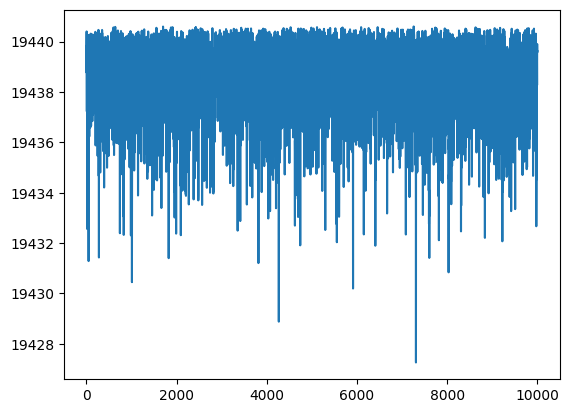

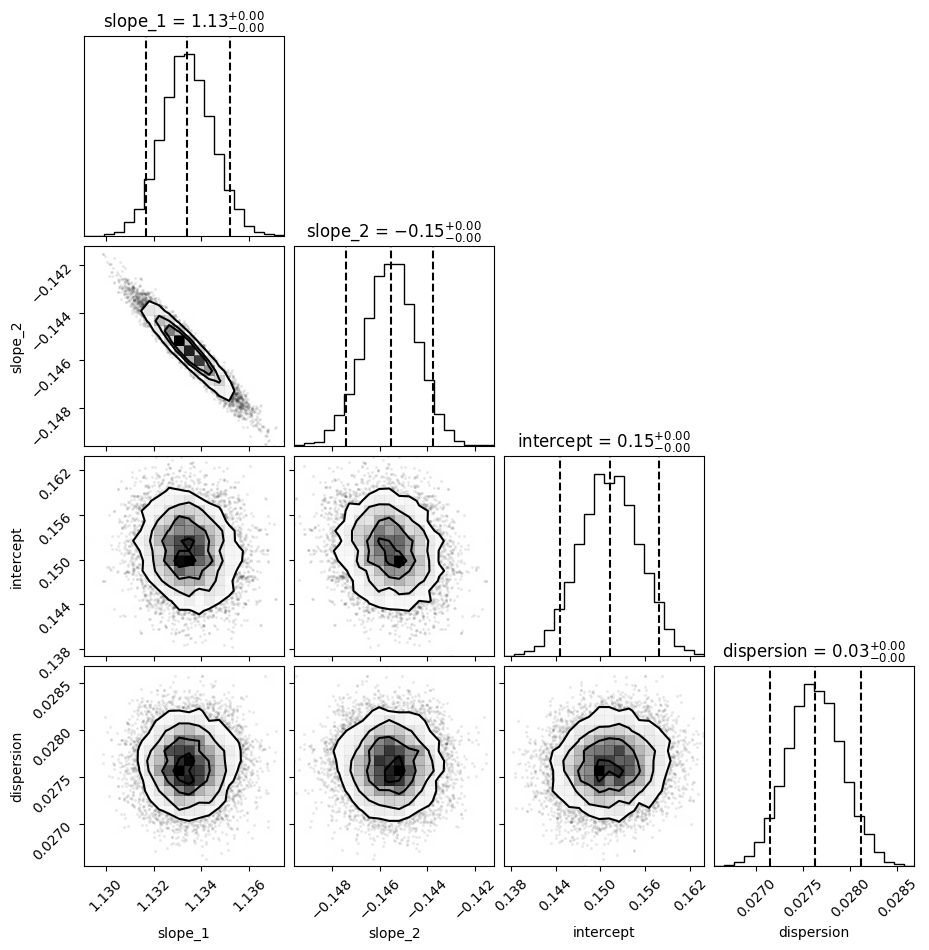

In [8]:
%%time

states, log_probs = least_squares(
    x=x,
    type='total',
    sigma2=sigma2,
    initial_slopes=initial_slopes,
    initial_intercept=initial_intercept,
    initial_dispersion=initial_dispersion,
    num_samples=10_000,
    nuts_kwargs=dict(step_size=1e-5),
)

plt.figure()
plt.plot(log_probs)

corner(
    data=np.asarray(states),
    labels=['slope_1', 'slope_2', 'intercept', 'dispersion'],
    quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
)

ChainStats.from_states(states)